# Exercise: 311 Requests

#### Summary

In NYC, you can call 311 with *anything* about the city - questions, complaints, etc. We'll be analyzing requests from 2015-2016 from the Department of Transportation and NYPD.

#### Data Source(s)

Filtered from full set, https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

#### Files

- `311-requests/311_Service_Requests_from_2010_to_Present.csv`, about 1.8 million rows (over 1GB of data)

#### Data dictionary

Visit [this page](https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9#schema-preview) and click 'Show more' on the bottom right of the list (53 columns).

#### Skills

- Opening large files
- Time

## Opening the file

It's a big one! If your computer is slow or you only have 2GB of RAM, you might want to specify `nrows=50000` (or less). Increase the number until it takes around 20 seconds, maybe!

In [144]:
import pandas as pd
import numpy as np
import re
import statistics
%matplotlib inline

### Measuring time in Jupyter Notebooks

How long did that take? Read it in again, but this time **time how long it takes.** (and no, not with your watch - with Jupyter!)

In [148]:
%%time
df = pd.read_csv('data/311_Service_Requests_from_2010_to_Present.csv', nrows=1000000)

<string>:2: DtypeWarning: Columns (17,47) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 15.4 s, sys: 7.02 s, total: 22.4 s
Wall time: 22.8 s


### Look at the first few rows

Make sure you can see **every single column.**

In [166]:
df.shape

(1000000, 53)

In [167]:
pd.set_option('display.max_columns', 65)
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Park Facility Name,Park Borough,School Name,School Number,School Region,School Code,School Phone Number,School Address,School City,School State,School Zip,School Not Found,School or Citywide Complaint,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,31463990,09/04/2015 10:55:25 PM,09/05/2015 02:06:54 AM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10460.0,1110 WYATT STREET,WYATT STREET,DEVOE AVENUE,BRONX PARK AVENUE,NaN,NaN,ADDRESS,BRONX,NaN,Precinct,Closed,09/05/2015 06:55:25 AM,The Police Department responded and upon arriv...,09/05/2015 02:06:54 AM,06 BRONX,BRONX,1018201.0,245083.0,Unspecified,BRONX,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.839306,-73.877301,"(40.83930620730105, -73.8773009180668)"
1,31463991,09/04/2015 01:53:45 PM,09/04/2015 06:37:24 PM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10031.0,NaN,NaN,NaN,NaN,WEST 151 STREET,BROADWAY,INTERSECTION,NEW YORK,NaN,Precinct,Closed,09/04/2015 09:53:45 PM,The Police Department responded to the complai...,09/04/2015 06:37:24 PM,09 MANHATTAN,MANHATTAN,998728.0,241754.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.830222,-73.947684,"(40.830222460372724, -73.94768359377827)"
2,31463992,09/04/2015 09:15:43 PM,09/04/2015 10:32:01 PM,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10031.0,545 WEST 144 STREET,WEST 144 STREET,AMSTERDAM AVENUE,BROADWAY,NaN,NaN,ADDRESS,NEW YORK,NaN,Precinct,Closed,09/05/2015 05:15:43 AM,The Police Department responded to the complai...,09/04/2015 10:32:02 PM,09 MANHATTAN,MANHATTAN,998263.0,239889.0,Unspecified,MANHATTAN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.825104,-73.949368,"(40.825104318551325, -73.94936777115372)"
3,31463993,09/05/2015 01:06:57 AM,09/05/2015 02:26:43 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11203.0,UTICA AVENUE,UTICA AVENUE,AVENUE D,FOSTER AVENUE,NaN,NaN,BLOCKFACE,BROOKLYN,NaN,Precinct,Closed,09/05/2015 09:06:57 AM,The Police Department responded to the complai...,09/05/2015 02:26:44 AM,17 BROOKLYN,BROOKLYN,1003890.0,172805.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.640965,-73.929232,"(40.64096464471428, -73.92923194083798)"
4,31463995,09/04/2015 07:48:25 AM,09/04/2015 05:21:18 PM,NYPD,New York City Police Department,Illegal Parking,Overnight Commercial Storage,Street/Sidewalk,11210.0,GLENWOOD ROAD,GLENWOOD ROAD,BROOKLYN AVENUE,EAST 37 STREET,NaN,NaN,BLOCKFACE,BROOKLYN,NaN,Precinct,Closed,09/04/2015 03:48:25 PM,The Police Department responded to the complai...,09/04/2015 05:21:19 PM,17 BROOKLYN,BROOKLYN,1000480.0,170405.0,Unspecified,BROOKLYN,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.634384,-73.941525,"(40.63438406330588, -73.9415248319131)"


### Speeding things up

We're going to be looking at open and close times, agencies, and the complaints (both types and descriptor). The only kind of location-based thing we'll want is borough.

**How much faster is it if we only read in those columns?**

In [168]:
df = pd.read_csv('data/311_Service_Requests_from_2010_to_Present.csv', nrows=1000000, usecols=['Created Date', 'Closed Date', 'Agency Name', 'Complaint Type', 'Descriptor', 'Borough'])

In [169]:
df.shape

(1000000, 6)

## Converting the 'Created Date' and 'Closed Date' columns to datetimes

### First, testing some things out

Let's take a look at converting **Created Date**, but **not all at once**.

1. Take 10,000 of them and try to convert them **without** a format string. Time it.
2. Take the same 10,000 and try to convert them **with** a format string. Time it.

If you tried to do all 1.8 million rows, **how long might it take with a format string vs without?**

In [170]:
%%time
pd.to_datetime(df['Created Date'].head(10000))

CPU times: user 2.35 s, sys: 7.29 ms, total: 2.35 s
Wall time: 2.36 s


0      2015-09-04 22:55:25
1      2015-09-04 13:53:45
2      2015-09-04 21:15:43
3      2015-09-05 01:06:57
4      2015-09-04 07:48:25
5      2015-09-04 11:31:12
6      2015-09-04 07:02:24
7      2015-09-04 12:34:05
8      2015-09-04 19:56:42
9      2015-09-04 21:04:42
10     2015-09-04 20:26:09
11     2015-09-04 11:07:15
12     2015-09-04 22:23:59
13     2015-09-04 23:16:12
14     2015-09-04 16:49:55
15     2015-09-04 14:39:46
16     2015-09-04 20:21:22
17     2015-09-04 23:34:23
18     2015-09-04 21:55:19
19     2015-09-04 23:44:07
20     2015-09-04 08:12:10
21     2015-09-04 23:14:40
22     2015-09-04 20:17:20
23     2015-09-04 22:54:59
24     2015-09-04 15:45:14
25     2015-09-04 23:48:20
26     2015-09-05 01:53:40
27     2015-09-04 23:34:47
28     2015-09-04 23:37:52
29     2015-09-04 23:01:37
               ...        
9970   2015-09-07 13:39:12
9971   2015-09-07 06:53:28
9972   2015-09-07 06:10:00
9973   2015-09-07 04:02:27
9974   2015-09-07 09:00:33
9975   2015-09-07 07:13:20
9

In [94]:
%%time
pd.to_datetime(df['Created Date'].head(10000), format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 62.4 ms, sys: 692 µs, total: 63.1 ms
Wall time: 62.8 ms


0      2015-09-04 22:55:25
1      2015-09-04 13:53:45
2      2015-09-04 21:15:43
3      2015-09-05 01:06:57
4      2015-09-04 07:48:25
5      2015-09-04 11:31:12
6      2015-09-04 07:02:24
7      2015-09-04 12:34:05
8      2015-09-04 19:56:42
9      2015-09-04 21:04:42
10     2015-09-04 20:26:09
11     2015-09-04 11:07:15
12     2015-09-04 22:23:59
13     2015-09-04 23:16:12
14     2015-09-04 16:49:55
15     2015-09-04 14:39:46
16     2015-09-04 20:21:22
17     2015-09-04 23:34:23
18     2015-09-04 21:55:19
19     2015-09-04 23:44:07
20     2015-09-04 08:12:10
21     2015-09-04 23:14:40
22     2015-09-04 20:17:20
23     2015-09-04 22:54:59
24     2015-09-04 15:45:14
25     2015-09-04 23:48:20
26     2015-09-05 01:53:40
27     2015-09-04 23:34:47
28     2015-09-04 23:37:52
29     2015-09-04 23:01:37
               ...        
9970   2015-09-07 13:39:12
9971   2015-09-07 06:53:28
9972   2015-09-07 06:10:00
9973   2015-09-07 04:02:27
9974   2015-09-07 09:00:33
9975   2015-09-07 07:13:20
9

### Creating new columns

Create new columns called `created_at` and `closed_at` from the `Created Date` and `Closed Date` columns. Do them individually, and **time them**.

In [171]:
%%time
df['created_at'] = pd.to_datetime(df['Created Date'], format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 5.09 s, sys: 27.8 ms, total: 5.11 s
Wall time: 5.11 s


In [172]:
%%time
df['closed_at'] = pd.to_datetime(df['Closed Date'], format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 5 s, sys: 40.2 ms, total: 5.05 s
Wall time: 5.08 s


### Confirming they look okay

Take a look at the first few rows to make sure the dates look correct, and then make sure their data type is `datetime64[ns]`.

In [173]:
df.head()

,Created Date,Closed Date,Agency Name,Complaint Type,Descriptor,Borough,created_at,closed_at
0,09/04/2015 10:55:25 PM,09/05/2015 02:06:54 AM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,BRONX,2015-09-04 22:55:25,2015-09-05 02:06:54
1,09/04/2015 01:53:45 PM,09/04/2015 06:37:24 PM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,MANHATTAN,2015-09-04 13:53:45,2015-09-04 18:37:24
2,09/04/2015 09:15:43 PM,09/04/2015 10:32:01 PM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,MANHATTAN,2015-09-04 21:15:43,2015-09-04 22:32:01
3,09/05/2015 01:06:57 AM,09/05/2015 02:26:43 AM,New York City Police Department,Noise - Commercial,Loud Music/Party,BROOKLYN,2015-09-05 01:06:57,2015-09-05 02:26:43
4,09/04/2015 07:48:25 AM,09/04/2015 05:21:18 PM,New York City Police Department,Illegal Parking,Overnight Commercial Storage,BROOKLYN,2015-09-04 07:48:25,2015-09-04 17:21:18


In [174]:
df.dtypes

Created Date              object
Closed Date               object
Agency Name               object
Complaint Type            object
Descriptor                object
Borough                   object
created_at        datetime64[ns]
closed_at         datetime64[ns]
dtype: object

# Examining agencies

Who has more 311 requests, the Department of Transportation or the NYPD?

In [175]:
df['Agency Name'].value_counts()

New York City Police Department    713505
Department of Transportation       286484
NYPD                                    5
Internal Affairs Bureau                 2
Investigation Review Section            2
DOT                                     2
Name: Agency Name, dtype: int64

In [176]:
df[df['Agency Name'].isin(['Department of Transportation', 'DOT'])].count()

Created Date      286486
Closed Date       283341
Agency Name       286486
Complaint Type    286486
Descriptor        286486
Borough           286486
created_at        286486
closed_at         283341
dtype: int64

In [177]:
df[df['Agency Name'].isin(['New York City Police Department', 'NYPD'])].count()

Created Date      713510
Closed Date       710253
Agency Name       713510
Complaint Type    713510
Descriptor        705791
Borough           713510
created_at        713510
closed_at         710253
dtype: int64

## What's the difference between "Complaint Type" and "Descriptor" columns?

In [178]:
df['Complaint Type'].value_counts().head()

Noise - Residential       240381
Illegal Parking           125198
Blocked Driveway          124199
Street Condition           95769
Street Light Condition     92951
Name: Complaint Type, dtype: int64

Complaint Tyep: "Full Agency name of responding City Government Agency", source: https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9#schema-preview

In [179]:
df['Descriptor'].value_counts().head()

Loud Music/Party    245017
No Access            92081
Street Light Out     73728
Banging/Pounding     69190
Pothole              59203
Name: Descriptor, dtype: int64

Descriptor: "This is associated to the Complaint Type, and provides further detail on the incident or condition. Descriptor values are dependent on the Complaint Type, and are not always required in SR.", source: https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9#schema-preview

## What are the most popular categories of complaints for the NYPD? For the DOT?

In [180]:
df_DOT = df[df['Agency Name'].isin(['Department of Transportation', 'DOT'])]

In [181]:
df_DOT['Complaint Type'].value_counts().head(1)

Street Condition    95768
Name: Complaint Type, dtype: int64

In [182]:
df_NYPD = df[df['Agency Name'].isin(['New York City Police Department', 'NYPD'])]

In [183]:
df_NYPD['Complaint Type'].value_counts().head(1)

Noise - Residential    240380
Name: Complaint Type, dtype: int64

## When people are complaining about street conditions, what are they usually complaining about?

In [185]:
df[df['Complaint Type'] == 'Street Condition']['Descriptor'].value_counts().head()

Pothole                           59110
Cave-in                           10212
Defective Hardware                 5816
Rough, Pitted or Cracked Roads     5144
Blocked - Construction             4078
Name: Descriptor, dtype: int64

## What kinds of noise are they complaining about when making residential noise complaints?

In [186]:
df[df['Complaint Type'] == 'Noise - Residential']['Descriptor'].value_counts().head()

Loud Music/Party    159276
Banging/Pounding     59465
Loud Talking         17484
Loud Television       4156
Name: Descriptor, dtype: int64

# Timing our complaints

How many complaints were filed each month?

- Tip: You'll probably want to `.set_index` first!

In [187]:
%%time
df.set_index('created_at', inplace=True)

CPU times: user 3.72 ms, sys: 2.99 ms, total: 6.71 ms
Wall time: 7.7 ms


In [188]:
df.head()

,Created Date,Closed Date,Agency Name,Complaint Type,Descriptor,Borough,closed_at
created_at,,,,,,,
2015-09-04 22:55:25,09/04/2015 10:55:25 PM,09/05/2015 02:06:54 AM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,BRONX,2015-09-05 02:06:54
2015-09-04 13:53:45,09/04/2015 01:53:45 PM,09/04/2015 06:37:24 PM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,MANHATTAN,2015-09-04 18:37:24
2015-09-04 21:15:43,09/04/2015 09:15:43 PM,09/04/2015 10:32:01 PM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,MANHATTAN,2015-09-04 22:32:01
2015-09-05 01:06:57,09/05/2015 01:06:57 AM,09/05/2015 02:26:43 AM,New York City Police Department,Noise - Commercial,Loud Music/Party,BROOKLYN,2015-09-05 02:26:43
2015-09-04 07:48:25,09/04/2015 07:48:25 AM,09/04/2015 05:21:18 PM,New York City Police Department,Illegal Parking,Overnight Commercial Storage,BROOKLYN,2015-09-04 17:21:18


In [189]:
df.index.month

Int64Index([9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
            ...
            8, 8, 8, 8, 8, 8, 8, 7, 8, 2],
           dtype='int64', name='created_at', length=1000000)

In [194]:
df.index.month.value_counts().sort_index()

1      68201
2      68178
3      78099
4      79555
5      91892
6      90978
7      81329
8      76072
9     144501
10     85619
11     65929
12     69647
Name: created_at, dtype: int64

## Plot how many requests were filed each month

In [115]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [116]:
df.shape

(1000000, 7)

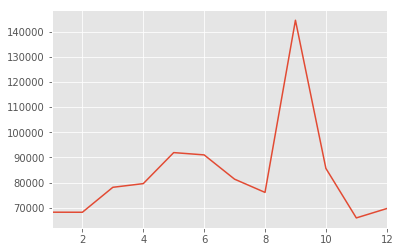

In [118]:
df.index.month.value_counts().sort_index().plot()

# Hmmm, it looks like a cycle

What could cause that? Try a couple comparisons to see if you can find out.

- Tip: Maybe the most popular summer complaints vs winter
- Tip: Maybe graphing the different agencies on the same graph

If you don't figure it out **that's okay!** 

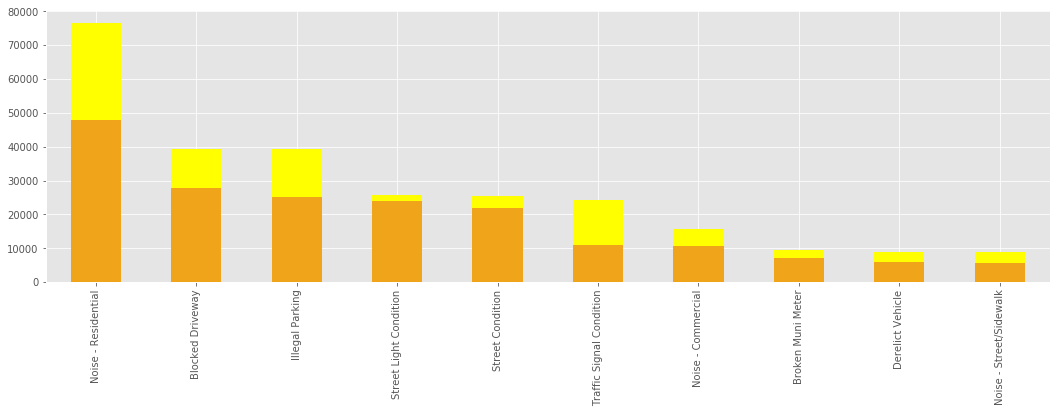

In [210]:
df[df.index.month.isin([8,9,10])]['Complaint Type'].value_counts().head(10).plot(kind='bar', color='yellow', figsize=(18,5))
df[df.index.month.isin([12,1,2])]['Complaint Type'].value_counts().head(10).plot(kind='bar', figsize=(18,5), alpha=0.5)

In [211]:
df.dtypes

Created Date              object
Closed Date               object
Agency Name               object
Complaint Type            object
Descriptor                object
Borough                   object
closed_at         datetime64[ns]
dtype: object

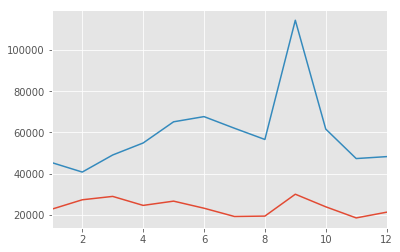

In [224]:
df[df['Agency Name'].isin(['Department of Transportation', 'DOT'])].index.month.value_counts().sort_index().plot()
df[df['Agency Name'].isin(['New York City Police Department', 'NYPD'])].index.month.value_counts().sort_index().plot()

## Time of day

### What time of day do people complain?

In [239]:
df.index.hour.value_counts().head()

23    70716
22    68129
21    58400
11    58179
0     56180
Name: created_at, dtype: int64

### What time of day do people complain about potholes?

In [237]:
df[df['Descriptor'] == 'Pothole'].index.hour.value_counts().head()

14    6510
13    5104
15    4858
7     4416
12    4187
Name: created_at, dtype: int64

In [243]:
df

,Created Date,Closed Date,Agency Name,Complaint Type,Descriptor,Borough,closed_at
created_at,,,,,,,
2015-09-04 22:55:25,09/04/2015 10:55:25 PM,09/05/2015 02:06:54 AM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,BRONX,2015-09-05 02:06:54
2015-09-04 13:53:45,09/04/2015 01:53:45 PM,09/04/2015 06:37:24 PM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,MANHATTAN,2015-09-04 18:37:24
2015-09-04 21:15:43,09/04/2015 09:15:43 PM,09/04/2015 10:32:01 PM,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,MANHATTAN,2015-09-04 22:32:01
2015-09-05 01:06:57,09/05/2015 01:06:57 AM,09/05/2015 02:26:43 AM,New York City Police Department,Noise - Commercial,Loud Music/Party,BROOKLYN,2015-09-05 02:26:43
2015-09-04 07:48:25,09/04/2015 07:48:25 AM,09/04/2015 05:21:18 PM,New York City Police Department,Illegal Parking,Overnight Commercial Storage,BROOKLYN,2015-09-04 17:21:18
2015-09-04 11:31:12,09/04/2015 11:31:12 AM,09/04/2015 03:01:54 PM,New York City Police Department,Illegal Parking,Overnight Commercial Storage,BROOKLYN,2015-09-04 15:01:54
2015-09-04 07:02:24,09/04/2015 07:02:24 AM,09/04/2015 01:55:53 PM,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,BROOKLYN,2015-09-04 13:55:53
2015-09-04 12:34:05,09/04/2015 12:34:05 PM,09/04/2015 01:38:47 PM,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,MANHATTAN,2015-09-04 13:38:47
2015-09-04 19:56:42,09/04/2015 07:56:42 PM,09/04/2015 09:18:31 PM,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,STATEN ISLAND,2015-09-04 21:18:31


### What time of day do people complain about loud parties?

In [242]:
df[df['Descriptor'] == 'Loud Music/Party'].index.hour.value_counts().head()

23    35930
22    30868
0     30687
1     22084
21    20810
Name: created_at, dtype: int64

## Days of the week

### What days of the week do people complain about potholes?

In [253]:
df[df['Descriptor'] == 'Pothole'].index.weekday.value_counts()

1    10997
2    10294
3    10259
0     9726
4     6923
6     6572
5     4432
Name: created_at, dtype: int64

### What days of the week do people complain about loud parties?

In [252]:
df[df['Descriptor'] == 'Loud Music/Party'].index.weekday.value_counts()

6    67303
5    66153
4    32655
0    22781
3    20564
2    18450
1    17111
Name: created_at, dtype: int64

### What do you think is the best kind of graph for describing day of the week complaints?

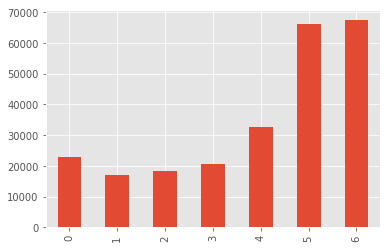

In [254]:
df[df['Descriptor'] == 'Loud Music/Party'].index.weekday.value_counts().sort_index().plot(kind='bar')

# Some more investigation

## Are there more homeless people in the city in the summer or in the winter?

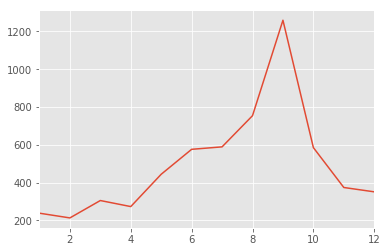

In [264]:
df[df['Complaint Type'] == 'Homeless Encampment'].index.month.value_counts().sort_index().plot()

## What holiday(s) are most popular for illegal fireworks?

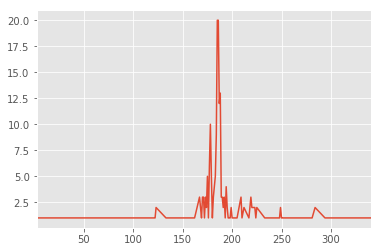

In [269]:
df[df['Complaint Type'] == 'Illegal Fireworks'].index.dayofyear.value_counts().sort_index().plot()

## Plot all kinds of noise complaints on top of each other

In [277]:
df[df['Complaint Type'].str.contains('Noise')]['Complaint Type'].value_counts()

Noise - Residential         240381
Noise - Street/Sidewalk      66769
Noise - Commercial           53285
Noise - Vehicle              25147
Noise - Park                  4543
Noise - House of Worship       981
Name: Complaint Type, dtype: int64

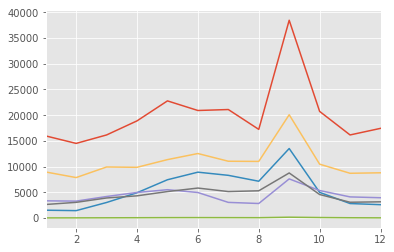

In [282]:
df[df['Complaint Type'].str.contains('Residential')].index.month.value_counts().sort_index().plot()
df[df['Complaint Type'].str.contains('Street/Sidewalk')].index.month.value_counts().sort_index().plot()
df[df['Complaint Type'].str.contains('Commercial')].index.month.value_counts().sort_index().plot()
df[df['Complaint Type'].str.contains('Vehicle')].index.month.value_counts().sort_index().plot()
df[df['Complaint Type'].str.contains('Park')].index.month.value_counts().sort_index().plot()
df[df['Complaint Type'].str.contains('House of Worship')].index.month.value_counts().sort_index().plot()